In [1]:
import numpy as np
from scipy import stats 
import math
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
from scipy.linalg import orth
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
# Device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
#FloatTensor
#DoubleTensor
dtype = torch.cuda.FloatTensor

Generate_data

In [2]:

def generate_data(R,n,d,big_sigma_squared,sigma_z,N):
    c=np.random.normal(loc=0, scale=1.0, size=[d,N])
    z=np.random.normal(loc=0, scale=sigma_z, size=[n,N])
    U=orth(np.random.normal(loc=0, scale=1, size=[n,d]))
    L=np.random.choice([-1,1],N)
    L=L.reshape(L.shape[0],1)     
    if R==None:
        R=1

    mu=R*U[:,0]
    mu=mu.reshape(mu.shape[0],1)
                
    U=U@big_sigma_squared
    X=U@c+mu@L.T 
    Y=X+z

    U = torch.from_numpy(U).type(dtype)
    X = torch.from_numpy(X).type(dtype)
    Y = torch.from_numpy(Y).type(dtype)
    L = torch.from_numpy(L).type(dtype)
    mu = torch.from_numpy(mu).type(dtype)
    
    return X,Y,U,L,mu

Compute the risk for a given estimator W subspace u ,distance mu and noise statistics sigma_z.

In [3]:
def test_risk_1(n,d,W,U,sigma_z,mu):    
    risk = torch.linalg.norm( (W - torch.eye(n).type(dtype)) @ U ,'fro')**2 + sigma_z**2 * torch.linalg.norm(W,'fro')**2+ torch.linalg.norm( (W- torch.eye(n).type(dtype)) @ mu )**2
    # 
    return risk/d

In [4]:
def test_risk_2 (mu,W1,W2,U,sigma_z):    
    a = (torch.norm(W2@W1@U)+torch.norm(sigma_z*(W2@W1))).item()    
    b = (W2@W1@mu).item()
    risk=0.5*(1-stats.norm.cdf(b,loc=0,scale=a)) + 0.5*(stats.norm.cdf(-b,loc=0,scale=a))
    return risk

In [5]:
n=1000
d=30
R=1 
alpha1=0.4
big_sigma_squared=np.eye(d)
sigma_z=0.5
train_size = [2,4,8,10,12,14,16,18,22,24,30,36,44,64,100,256]#,512,1024,2048,4096,8192,16384]
#train_size= range(1,200,20)
runs=5



In [6]:
learn_results = {'test_l':np.zeros([runs,len(train_size)]),'test_l2':np.zeros([runs,len(train_size)]),'test_l3':np.zeros([runs,len(train_size)]),'test_l4':np.zeros([runs,len(train_size)])}
opt=np.zeros([runs,len(train_size)])
for r in range(runs):
    print("**********run {}**********".format(r))
    for i,N in enumerate(train_size):
        print("*****training size (N) = {}*****".format(N))
        X,Y,U,L,mu = generate_data(R,n,d,big_sigma_squared,sigma_z,N)
        
        L=L.T
        Xpi=torch.pinverse(X)
        Ypi=torch.pinverse(Y)
        Lpi=torch.pinverse(L)

        W1=X@Ypi
        a1=test_risk_1(n,d,W1,U,sigma_z,mu)


        W2=alpha1*Xpi.T@L.T@L@Xpi+(1-alpha1)*torch.eye(n).type(dtype)
        W2=torch.pinverse(W2)@(alpha1* (Xpi.T@L.T@L@Ypi) + (1-alpha1)* (X@Ypi))
        #@Y.T@torch.pinverse(X@Y.T)
        #W2=torch.pinverse(W2)
        #W2=W2@L@Ypi
        a2=test_risk_1(n,d,W2,U,sigma_z,mu)

        #  torch.linalg.inv    torch.pinverse
        #W3= (U@U.T+mu@mu.T) @   torch.pinverse(U@U.T+mu@mu.T+(sigma_z**2*torch.eye(n).type(dtype)))
        #W3=(1/(1+sigma_z**2))*U@U.T+ ((1+R**2)/(1+sigma_z**2+R**2)-(1/(1+sigma_z**2)))*mu@mu.T
        #a3=torch.linalg.norm( (mu@mu.T - torch.eye(n).type(dtype)) @ U ,'fro')**2/d + (n+R**2)/d*sigma_z**2 + torch.linalg.norm( (U@U.T - torch.eye(n).type(dtype)) @ mu ,'fro')**2/d
        #'''
        b=((1+R**2)*(1+sigma_z**2)-(1+sigma_z**2+R**2))/((1/(1+sigma_z**2))*(1+sigma_z**2+R**2))
        c=sigma_z**2/(1+sigma_z**2)
        a3=(b-c)**2+sigma_z**2*((1+R**2)/(1+R**2+sigma_z**2))**2+(d-1)*c+(sigma_z**2*R/(1+sigma_z**2+R**2))**2
        a3=a3/d
        #'''
        #a3=test_risk_1(n,d,W3,U,sigma_z,mu)

        a4=test_risk_2 (mu,W2,L@torch.pinverse(W2@Y),U,sigma_z)
        a5=test_risk_2 (mu,torch.eye(n).type(dtype),L@Ypi,U,sigma_z)
        

        opt[r,i]= a3
        learn_results['test_l'][r,i] = a1
        learn_results['test_l2'][r,i] = a2
        learn_results['test_l3'][r,i] = a4
        learn_results['test_l4'][r,i] = a5

results1m=learn_results['test_l'].mean(0)
results1s=learn_results['test_l'].std(0)
results2m=learn_results['test_l2'].mean(0)
results2s=learn_results['test_l2'].std(0)
results3m=learn_results['test_l3'].mean(0)
results3s=learn_results['test_l3'].std(0)
results4m=learn_results['test_l4'].mean(0)
results4s=learn_results['test_l4'].std(0)

**********run 0**********
*****training size (N) = 2*****
*****training size (N) = 4*****
*****training size (N) = 8*****
*****training size (N) = 10*****
*****training size (N) = 12*****
*****training size (N) = 14*****
*****training size (N) = 16*****
*****training size (N) = 18*****
*****training size (N) = 22*****
*****training size (N) = 24*****
*****training size (N) = 30*****
*****training size (N) = 36*****
*****training size (N) = 44*****
*****training size (N) = 64*****
*****training size (N) = 100*****
*****training size (N) = 256*****
**********run 1**********
*****training size (N) = 2*****
*****training size (N) = 4*****
*****training size (N) = 8*****
*****training size (N) = 10*****
*****training size (N) = 12*****
*****training size (N) = 14*****
*****training size (N) = 16*****
*****training size (N) = 18*****
*****training size (N) = 22*****
*****training size (N) = 24*****
*****training size (N) = 30*****
*****training size (N) = 36*****
*****training size (N) = 44*

In [7]:
results2m

array([1.02161417, 1.00811822, 0.985506  , 0.97329401, 0.9614875 ,
       0.95094063, 0.93907539, 0.92473011, 0.9082564 , 0.89787792,
       0.86808811, 1.23690302, 1.03398263, 1.03334146, 1.03333626,
       1.03333495])

In [8]:
results1m

array([1.02161417, 1.00811825, 0.985506  , 0.97329401, 0.9614875 ,
       0.95094063, 0.93907537, 0.92473013, 0.90825639, 0.89787794,
       0.86808826, 0.83725227, 0.81319546, 0.73680633, 0.63912437,
       0.43496361])

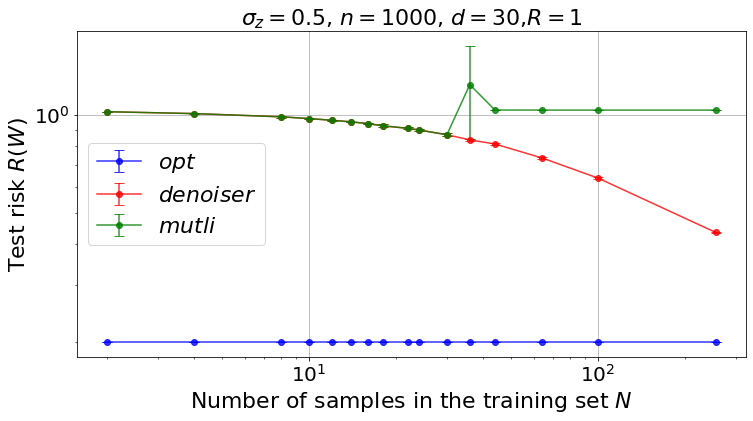

In [9]:
fontsize = 22

fig = plt.figure(figsize=(12,6))
al=0.8
ax = fig.add_subplot(111)

ax.errorbar(train_size, opt.mean(0), yerr=opt.std(0), color='b', fmt="-o",alpha=al,label=r"$opt$", capsize=5)
ax.errorbar(train_size, results1m, yerr=results1s, color='r', fmt="-o",alpha=al,label=r"$denoiser$", capsize=5)
ax.errorbar(train_size, results2m, yerr=results2s, color='g', fmt="-o",alpha=al,label=r"$mutli$", capsize=5)

ax.set_xlabel("Number of samples in the training set $N$", fontsize=fontsize)
ax.set_ylabel(r"Test risk $R(W)$", fontsize=fontsize)
ax.legend(fontsize=fontsize)
ax.set_title('$\sigma_z=${}, $n=${}, $d=${},$R=${}'.format(sigma_z,n,d,R), fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize-2 ) 
ax.tick_params(axis='y', labelsize=fontsize-2 ) 
base =10
ax.set_yscale('log')

ax.set_xscale('log')
#ax.set_ylim([0,20])

plt.grid()
plt.show()

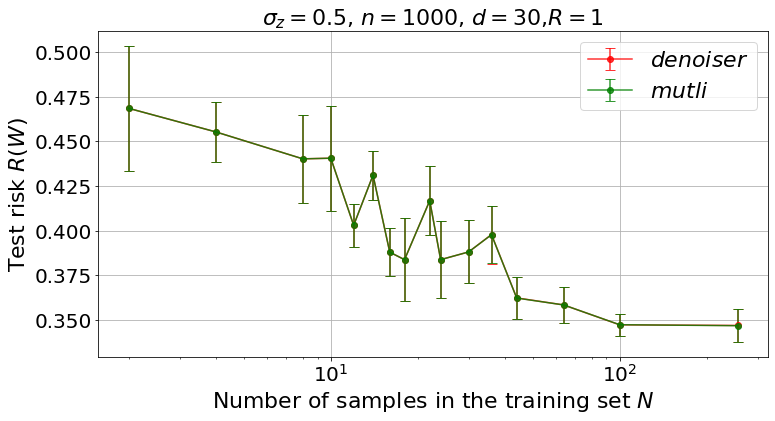

In [10]:
fontsize = 22

fig = plt.figure(figsize=(12,6))
al=0.8
ax = fig.add_subplot(111)


ax.errorbar(train_size, results3m, yerr=results3s, color='r', fmt="-o",alpha=al,label=r"$denoiser$", capsize=5)
ax.errorbar(train_size, results4m, yerr=results4s, color='g', fmt="-o",alpha=al,label=r"$mutli$", capsize=5)

ax.set_xlabel("Number of samples in the training set $N$", fontsize=fontsize)
ax.set_ylabel(r"Test risk $R(W)$", fontsize=fontsize)
ax.legend(fontsize=fontsize)
ax.set_title('$\sigma_z=${}, $n=${}, $d=${},$R=${}'.format(sigma_z,n,d,R), fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize-2 ) 
ax.tick_params(axis='y', labelsize=fontsize-2 ) 
base =10
#ax.set_yscale('log')

ax.set_xscale('log')
#ax.set_ylim([0,20])

plt.grid()
plt.show()